In [1]:
import sys
import torch
import lightning as L
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchmetrics import JaccardIndex

sys.path.append("/home/szhang16/unet")
from models import LightningModel
from abidatamodule import AbiChipDataset

BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 14
LEARNING_RATE = 1e-4
TRAINING_SPLIT = 0.8
EPOCHS = 100
DATALOADER_WORKERS = 71

/panfs/ccds02/app/modules/miniforge/platform/x86_64/rhel/8.10/24.9.0/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
satmodel = LightningModel.load_from_checkpoint("/explore/nobackup/people/szhang16/checkpoints/satfull/best-epoch=28-val_loss=0.35.ckpt",
    model_name="SatVisionUNet", in_channels=IMG_CHANNELS, num_classes=1, lr=LEARNING_RATE, freeze_encoder=True, final_size=(91, 40)
)
unetmodel = LightningModel.load_from_checkpoint("/explore/nobackup/people/szhang16/checkpoints/unetfull/best-epoch=41-val_loss=0.35.ckpt", model_name="UNet", in_channels=IMG_CHANNELS, num_classes=1, lr=LEARNING_RATE, freeze_encoder=False)

=> merge config from /home/szhang16/.cache/huggingface/hub/models--nasa-cisto-data-science-group--satvision-toa-giant-patch8-window8-128/snapshots/ba822b094db803110d38c35aed889cf65689eef5/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml


/panfs/ccds02/app/modules/miniforge/platform/x86_64/rhel/8.10/24.9.0/envs/torch/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
rgb_indices = [0, 2, 2]
iou = JaccardIndex(task="binary", num_classes=2)

In [11]:
total_chips = glob.glob("/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/GOES-16/*.npz")
test_idx = int(len(total_chips) * 0.9)
chip_sample = random.sample(total_chips[test_idx:], 20)

dataset = AbiChipDataset(chip_sample)

/explore/nobackup/people/szhang16/.nccstmp/ipykernel_3061707/3157111193.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(dataset[i]['chip'].unsqueeze(0)).cuda()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02567784..1.0228552].


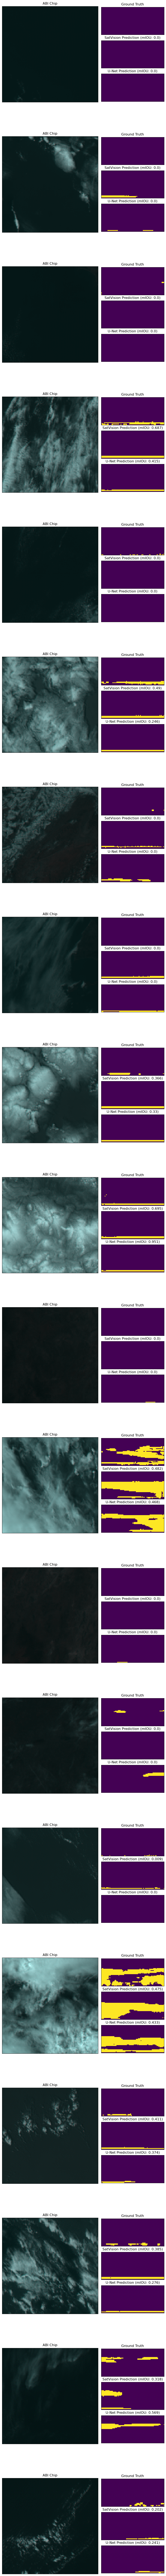

In [12]:
fig = plt.figure(figsize=(10, 160))

gs_main = gridspec.GridSpec(20, 5, figure=fig, hspace=0.3, wspace=0.1)

for i in range(20):
    inputs = torch.tensor(dataset[i]['chip'].unsqueeze(0)).cuda()
    satpred = satmodel(inputs).cpu()
    unetpred = unetmodel(inputs).cpu()
    rgbchip = dataset[i]['chip'][rgb_indices, ...].permute(1, 2, 0)
    ax_left = fig.add_subplot(gs_main[i, :3])
    ax_left.imshow(rgbchip)
    ax_left.set_title("ABI Chip")
    ax_left.set_xticks([])
    ax_left.set_yticks([])
    
    gs_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_main[i, 3:], hspace=0)

    groundtruth = dataset[i]['mask']

    satiou = np.round(iou(satpred, groundtruth.unsqueeze(0)).numpy().astype(float), 3)
    unetiou = np.round(iou(unetpred, groundtruth.unsqueeze(0)).numpy().astype(float), 3)
    
    groundtruth = np.transpose(groundtruth.squeeze(), (1, 0))
    groundtruth = torch.flip(groundtruth, dims=[0])

    satpred = (torch.sigmoid(satpred) > 0.5).cpu().detach().numpy().squeeze()
    satpred = np.transpose(satpred, (1, 0))
    satpred = satpred[::-1, ...]

    unetpred = (torch.sigmoid(unetpred) > 0.5).cpu().detach().numpy().squeeze()
    unetpred = np.transpose(unetpred, (1, 0))
    unetpred = unetpred[::-1, ...]

    
    
    ax_right = fig.add_subplot(gs_right[0, 0])
    ax_right.imshow(groundtruth)
    ax_right.set_title("Ground Truth")
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    ax_right = fig.add_subplot(gs_right[1, 0])
    ax_right.imshow(satpred)
    ax_right.set_title(f"SatVision Prediction (mIOU: {satiou})")
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    ax_right = fig.add_subplot(gs_right[2, 0])
    ax_right.imshow(unetpred)
    ax_right.set_title(f"U-Net Prediction (mIOU: {unetiou})")
    ax_right.set_xticks([])
    ax_right.set_yticks([])